In [1]:
import pandas as pd
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity
from scipy.spatial.distance import euclidean
import matplotlib.pyplot as plt
from scipy.stats import shapiro, levene, ttest_ind, mannwhitneyu
import seaborn as sns
from tqdm import tqdm

In [2]:
# Load data
users_role = pd.read_csv('../../src/data/distribuitions/hub_bridge_df.csv')
user_embeddings = np.load('../../src/nlp/user_embeddings.npy', allow_pickle=True)
community_embeddings = np.load('../../src/nlp/community_embeddings.npy', allow_pickle=True)

# Convert embeddings into dict
user_emb_dict = {uid: emb for uid, emb in user_embeddings}
community_emb_dict = {cid: emb for cid, emb in community_embeddings}

In [3]:
# Map embeddings to dataframe
users_role['user_embedding'] = users_role['id'].map(user_emb_dict)
users_role['community_embedding'] = users_role['community_id'].map(community_emb_dict)

# Define roles including peripherals
users_role['role'] = np.where(users_role['is_hub'], 'Hub', np.where(users_role['is_bridge'], 'Bridge', 'Average'))

In [4]:
# Defyining Leave-one-out embedding to avoid auto-influence
def leave_one_out_embeddings(df):
    embeddings = np.stack(df['user_embedding'])
    weights = df['id'].map(df['id'].value_counts()).to_numpy()

    loo_list = []
    for i in tqdm(range(len(df))):
        mask = np.ones(len(df), dtype=bool)
        mask[i] = False
        if mask.sum() == 0:  
            # se la community ha un solo utente → non puoi escludere
            loo_list.append(embeddings[i])  
        else:
            loo_list.append(
                np.average(embeddings[mask], axis=0, weights=weights[mask])
            )
    return pd.Series(loo_list, index=df.index)

users_role['loo_community_embedding'] = (
    users_role.groupby('community_id', group_keys=False)
    .apply(leave_one_out_embeddings)
)


100%|██████████| 2/2 [00:00<00:00, 6492.73it/s]
/tmp/ipykernel_7322/3918020287.py:21: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(leave_one_out_embeddings)


In [5]:
# Compute similarity metrics
def compute_metrics(row):
    u_emb = np.array(row['user_embedding']).reshape(1, -1)
    c_emb = np.array(row['loo_community_embedding']).reshape(1, -1)
    
    cos_sim = cosine_similarity(u_emb, c_emb)[0][0]
    
    return pd.Series({'cosine_similarity': cos_sim})

metrics_df = users_role.apply(compute_metrics, axis=1)
users_role = pd.concat([users_role, metrics_df], axis=1)

In [6]:
# Summary statistics per role and community type
summary_stats = users_role.groupby(['community_type', 'role']).agg(
    count=('id', 'count'),
    mean_cosine=('cosine_similarity', 'mean'),
    median_cosine=('cosine_similarity', 'median'),
    std_cosine=('cosine_similarity', 'std'),
).reset_index()

summary_stats.to_csv('../../src/research_question/rq2_summary_stats.csv', index=False)
summary_stats

,community_type,role,count,mean_cosine,median_cosine,std_cosine
0,Moderate,Average,184,0.711643,0.720056,0.100767
1,Moderate,Bridge,32,0.709923,0.719942,0.110415
2,Moderate,Hub,1,0.751803,0.751803,NaN
3,Strong,Average,3646,0.744316,0.759020,0.111606
4,Strong,Bridge,237,0.756232,0.767714,0.100542
5,Strong,Hub,142,0.749949,0.758066,0.144831
6,Very Strong,Average,3214,0.737007,0.752407,0.105009
7,Very Strong,Bridge,174,0.756403,0.769781,0.089708
8,Very Strong,Hub,120,0.796879,0.815258,0.115804
9,Weak,Average,27,0.674292,0.714784,0.113141


### Statistical test

In [7]:
results = []
for ctype in users_role['community_type'].unique():
    subset = users_role[users_role['community_type'] == ctype]
    for role1, role2 in [('Average','Hub'), ('Average','Bridge'), ('Hub','Bridge')]:
        g1 = subset[subset['role'] == role1]['cosine_similarity'].dropna()
        g2 = subset[subset['role'] == role2]['cosine_similarity'].dropna()
        
        if len(g1) > 2 and len(g2) > 2:
            # normality test
            _, p1 = shapiro(g1)
            _, p2 = shapiro(g2)
            if p1 > 0.05 and p2 > 0.05:
                # homogeneous variance
                _, plevene = levene(g1, g2)
                test = ttest_ind(g1, g2, equal_var=(plevene > 0.05))
                test_name = 't-test'
            else:
                test = mannwhitneyu(g1, g2, alternative='two-sided')
                test_name = 'Mann–Whitney'
            results.append((ctype, role1, role2, test_name, test.pvalue))

pd.DataFrame(results, columns=['community_type','role1','role2','test','pvalue'])

,community_type,role1,role2,test,pvalue
0,Very Strong,Average,Hub,Mann–Whitney,3.802308e-10
1,Very Strong,Average,Bridge,Mann–Whitney,2.998026e-02
2,Very Strong,Hub,Bridge,Mann–Whitney,7.656061e-05
3,Strong,Average,Hub,Mann–Whitney,3.575047e-01
4,Strong,Average,Bridge,Mann–Whitney,2.146625e-01
5,Strong,Hub,Bridge,Mann–Whitney,9.517236e-01
6,Weak,Average,Bridge,Mann–Whitney,6.320275e-01
7,Moderate,Average,Bridge,Mann–Whitney,9.377104e-01


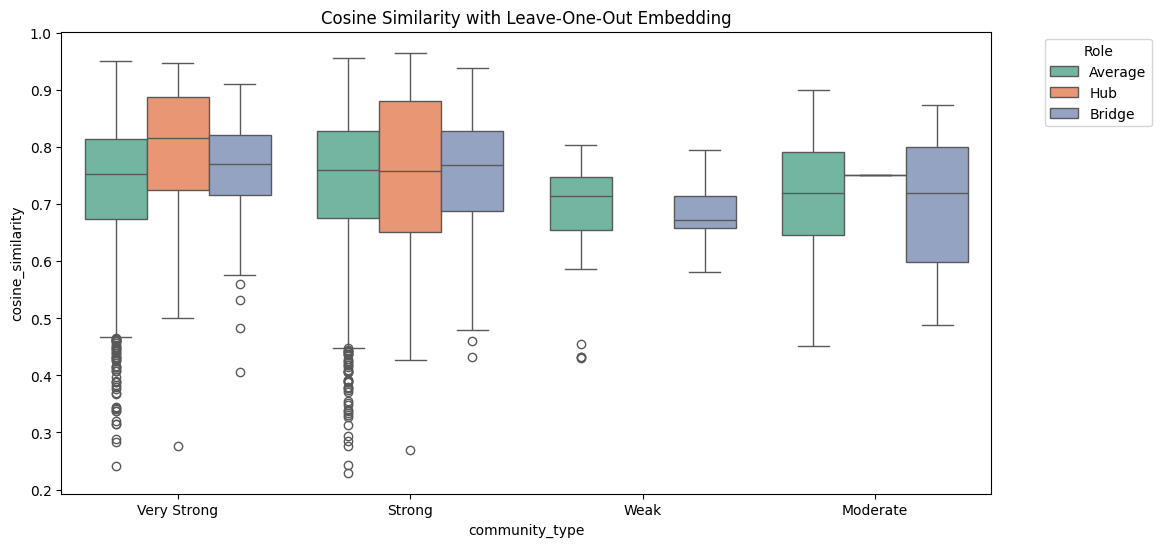

In [8]:
plt.figure(figsize=(12,6))
sns.boxplot(data=users_role, x='community_type', y='cosine_similarity', hue='role', palette='Set2')
plt.title('Cosine Similarity with Leave-One-Out Embedding')
plt.legend(bbox_to_anchor=(1.05,1), title='Role')
plt.show()


## Topic Distribution

In [9]:
topics = pd.read_csv('../../src/nlp/topic_modeling/topic_data.csv')

In [ ]:
users_role = users_role.merge(topics, left_on='id', right_on='author', how='inner')

,id_x,degree,internal_degree,community_id,community_type,external_degree,pct_internal,pct_external,z_internal,betweenness,...,role,loo_community_embedding,cosine_similarity,author,id_y,type,date,lemmatized_text,topic,topic_id
0,-Dead-Eye-Duncan-,32,32,0,Very Strong,0,1.0,0.0,0.336253,3672.693028,...,Average,"[0.008347741317859562, -0.003134968513530719, ...",0.654804,-Dead-Eye-Duncan-,1lyvcd4,post,2025-07-13T15:18:35+00:00,european city local protest amount tourism go ...,18_housing_suburbs_gentrification_neighborhoods,18
1,-Dead-Eye-Duncan-,32,32,0,Very Strong,0,1.0,0.0,0.336253,3672.693028,...,Average,"[0.008347741317859562, -0.003134968513530719, ...",0.654804,-Dead-Eye-Duncan-,n2x7kqt,comment,2025-07-13T16:34:29+00:00,talk small percentage people people american e...,18_housing_suburbs_gentrification_neighborhoods,18
2,-Dead-Eye-Duncan-,32,32,0,Very Strong,0,1.0,0.0,0.336253,3672.693028,...,Average,"[0.008347741317859562, -0.003134968513530719, ...",0.654804,-Dead-Eye-Duncan-,n2wzdd9,comment,2025-07-13T15:53:01+00:00,ism true issue government handle see would end...,0_democrats_voters_dems_votes,0
3,-Dead-Eye-Duncan-,32,32,0,Very Strong,0,1.0,0.0,0.336253,3672.693028,...,Average,"[0.008347741317859562, -0.003134968513530719, ...",0.654804,-Dead-Eye-Duncan-,n2x722x,comment,2025-07-13T16:31:51+00:00,still owner choose tourist local certain area ...,18_housing_suburbs_gentrification_neighborhoods,18
4,-Dead-Eye-Duncan-,32,32,0,Very Strong,0,1.0,0.0,0.336253,3672.693028,...,Average,"[0.008347741317859562, -0.003134968513530719, ...",0.654804,-Dead-Eye-Duncan-,n2x69bh,comment,2025-07-13T16:27:46+00:00,visitor stay permanently typically tourist wou...,18_housing_suburbs_gentrification_neighborhoods,18
